<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [ ]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:

if not os.path.exists('./songs_dataset'):
    if not os.path.exists('songs_dataset.zip'):
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip



--2025-12-03 13:08:56--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-12-03 13:08:57--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2075036 (2.0M) [application/zip]
Saving to: ‘songs_dataset.zip’

songs_dataset.zi

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

['leonard-cohen.txt',
 'johnny-cash.txt',
 'jimi-hendrix.txt',
 'paul-simon.txt',
 'nickelback.txt',
 'lin-manuel-miranda.txt',
 'nicki-minaj.txt',
 'radiohead.txt',
 'dr-seuss.txt',
 'adele.txt',
 'kanye-west.txt',
 'prince.txt',
 'britney-spears.txt',
 'r-kelly.txt',
 'al-green.txt',
 'Lil_Wayne.txt',
 'bjork.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'lil-wayne.txt',
 'notorious_big.txt',
 'nirvana.txt',
 'joni-mitchell.txt',
 'kanye.txt',
 'michael-jackson.txt',
 'eminem.txt',
 'bob-marley.txt',
 'bieber.txt',
 'notorious-big.txt',
 'nursery_rhymes.txt',
 'rihanna.txt',
 'blink-182.txt',
 'ludacris.txt',
 'dolly-parton.txt',
 'drake.txt',
 'missy-elliott.txt',
 'beatles.txt',
 'janisjoplin.txt',
 'lady-gaga.txt',
 'amy-winehouse.txt',
 'cake.txt',
 'bob-dylan.txt',
 'bruce-springsteen.txt',
 'dickinson.txt',
 'lorde.txt',
 'disney.txt',
 'bruno-mars.txt',
 'patti-smith.txt',
 'Kanye_West.txt']

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3849064916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df[0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(s) for s in segmented_sentences]

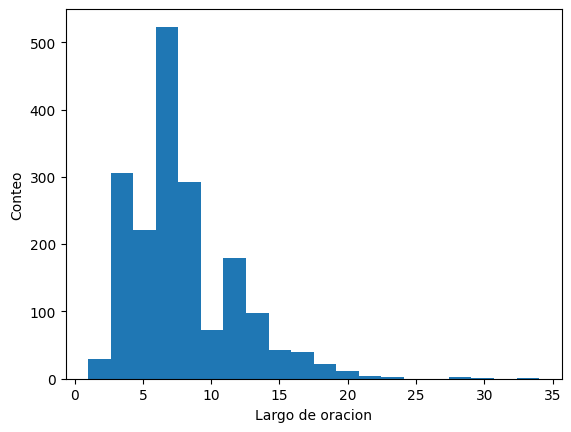

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences, bins=20)
plt.xlabel("Largo de oracion")
plt.ylabel("Conteo")
plt.show()

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences

[[200, 10, 12, 907, 908, 42, 909, 121],
 [22, 13, 638, 91, 217, 349, 79, 4, 314],
 [23, 2, 160, 9, 200, 520, 35, 83, 910, 3, 78, 2, 911, 4, 15],
 [173, 7, 912, 913, 397, 8],
 [23, 200, 218, 520, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200],
 [175,
  175,
  175,
  175,
  175,
  175,
  175,
  36,
  2,
  230,
  522,
  9,
  398,
  17,
  914,
  639,
  640,
  133,
  4,
  8],
 [447, 162, 17, 315, 29, 13, 15],
 [5, 9, 12, 915, 17, 916, 19, 20, 189, 74, 9, 917, 17, 8],
 [447, 162, 17, 315, 29, 13, 15],
 [29, 13, 15, 29, 13, 15, 29, 13, 15, 29, 13, 15],
 [448, 162, 17, 315, 29, 13, 15, 5, 36, 3, 399, 918, 107, 3

In [ ]:
vocab_size = len(tok.word_index)

In [ ]:
max_context_size+1

13

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val = train_test_split(tokenized_sentences, test_size=0.2, random_state=42)


Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(15325, 13)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
y.shape

(15325,)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'yesterday': 10, 'troubles': 1, 'far': 1, 'my': 134, 'away': 21, 'seemed': 1, 'all': 177, 'so': 61, "they're": 5, 'as': 25, 'now': 90, 'stay': 7, 'it': 125, 'looks': 2, 'here': 33, 'to': 307, 'though': 11, 'the': 376, 'i': 400, 'oh': 77, 'half': 1, 'in': 186, 'used': 1, "i'm": 66, 'be': 108, 'believe': 15, 'suddenly': 3, 'not': 32, 'man': 34, 'hanging': 1, 'shadow': 1, 'over': 5, 'a': 270, 'me': 219, "there's": 14, 'she': 90, 'why': 20, 'had': 19, "don't": 74, 'say': 76, 'know': 132, "wouldn't": 4, 'came': 11, 'go': 38, 'something': 13, 'such': 9, 'game': 3, 'wrong': 6, 'love': 181, 'was': 48, 'play': 10, 'long': 25, 'for': 62, 'an': 15, 'easy': 9, 'said': 14, 'hide': 13, 'place': 10, 'need': 51, 'times': 5, 'mm': 3, 'find': 10, 'trouble': 1, 'of': 109, 'mother': 2, 'when': 71, 'myself': 3, 'mary': 2, 'comes': 20, 'words': 14, 'let': 55, 'wisdom': 7, 'speaking': 4, 'standing': 13, 'hour': 1, 'darkness': 1, 'and': 311, 'right': 25, 'front': 1, 'is': 89, 'worl

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)

# Dataset y DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)



### Perplexity


In [ ]:
import math

def perplexity(loss_value: float) -> float:
    """Calcula perplexity a partir del valor de loss promedio."""
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float('inf')


### Definir el modelo

In [ ]:
class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, num_classes=None, max_context_size=3):
        super(TextModel, self).__init__()

        # Embedding:
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embed_dim)

        # LSTMs: el primero devuelve secuencia completa
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, vocab_size+1)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embed_dim)

        # Primer LSTM: return_sequences=True equivale a quedarse con toda la salida
        x, _ = self.lstm1(x)   # (batch, seq_len, hidden_dim)
        x = self.dropout(x)

        # Segundo LSTM: sin return_sequences -> solo último estado oculto
        x, (h_n, c_n) = self.lstm2(x)  # x = (batch, seq_len, hidden_dim)
        x = h_n[-1]                    # último hidden state: (batch, hidden_dim)

        x = F.relu(self.fc1(x))
        logits = self.fc2(x)           # (batch, vocab_size+1)
        return logits

    def predict(self,x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [ ]:
model = TextModel(vocab_size=vocab_size, embed_dim=5, hidden_dim=64, num_classes=vocab_size+1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Entrenamiento
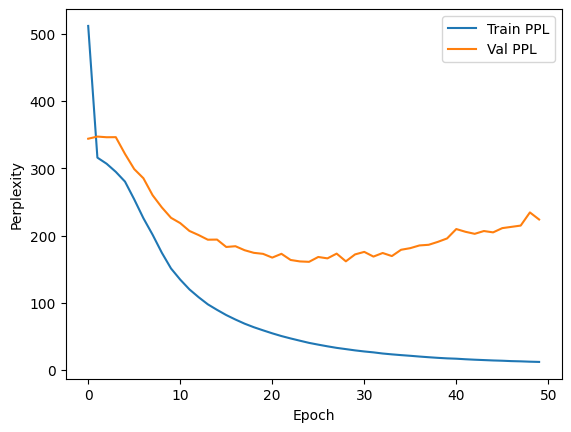

In [ ]:
epochs = 30

# Historial de métricas
history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
    "val_acc": []
}

for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)  # (batch, vocab_size+1)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    avg_train_loss = train_loss / len(train_ds)
    train_ppl = perplexity(avg_train_loss)

    # --- Validación ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_ds)
    val_ppl = perplexity(avg_val_loss)
    val_acc = correct / total

    # Guardar métricas
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f}"
          )

Epoch 1/30 | Train Loss: 6.2049 | Train PPL: 495.19 | Val Loss: 5.8392 | Val PPL: 343.50
Epoch 2/30 | Train Loss: 5.7402 | Train PPL: 311.12 | Val Loss: 5.8130 | Val PPL: 334.61
Epoch 3/30 | Train Loss: 5.6802 | Train PPL: 293.01 | Val Loss: 5.8039 | Val PPL: 331.59
Epoch 4/30 | Train Loss: 5.6304 | Train PPL: 278.77 | Val Loss: 5.7793 | Val PPL: 323.53
Epoch 5/30 | Train Loss: 5.5667 | Train PPL: 261.57 | Val Loss: 5.7149 | Val PPL: 303.34
Epoch 6/30 | Train Loss: 5.4880 | Train PPL: 241.77 | Val Loss: 5.6896 | Val PPL: 295.79
Epoch 7/30 | Train Loss: 5.3879 | Train PPL: 218.75 | Val Loss: 5.6168 | Val PPL: 275.01
Epoch 8/30 | Train Loss: 5.2802 | Train PPL: 196.41 | Val Loss: 5.5835 | Val PPL: 266.00
Epoch 9/30 | Train Loss: 5.1864 | Train PPL: 178.82 | Val Loss: 5.5336 | Val PPL: 253.04
Epoch 10/30 | Train Loss: 5.0717 | Train PPL: 159.45 | Val Loss: 5.4457 | Val PPL: 231.76
Epoch 11/30 | Train Loss: 4.9574 | Train PPL: 142.22 | Val Loss: 5.4052 | Val PPL: 222.57
Epoch 12/30 | Train

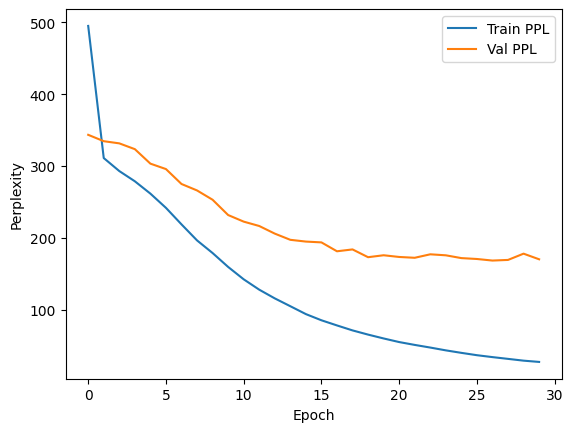

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history["train_ppl"], label="Train PPL")
plt.plot(history["val_ppl"], label="Val PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


In [ ]:
import torch

def predict_next_word(model, tokenizer, text, max_len, device="cpu"):
    model.eval()

    # Codificar texto a secuencia de índices
    encoded = tokenizer.texts_to_sequences([text])[0]

    # Padding/truncamiento manual
    if len(encoded) < max_len:
        encoded = [0] * (max_len - len(encoded)) + encoded
    else:
        encoded = encoded[-max_len:]

    # Convertir a tensor y mover a device
    x = torch.as_tensor([encoded], dtype=torch.long, device=device)

    with torch.no_grad():
        y_hat = model.forward(x)  # logits (1, vocab_size+1)

    # Índice de la palabra predicha
    idx = y_hat.argmax(dim=1).item()

    # Buscar la palabra en el tokenizer
    for word, i in tokenizer.word_index.items():
        if i == idx:
            return word
    return ""  # fallback si no encuentra

def generate_seq(model, tokenizer, seed_text, n_words, max_len, device="cpu"):
    output = seed_text
    for _ in range(n_words):
        next_word = predict_next_word(model, tokenizer, output, max_len, device)
        output += " " + next_word
    return output





### Predicción de próxima palabra

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text,device="cpu"):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    encoded_tens = torch.as_tensor(encoded, dtype=torch.long, device=device)

    y_hat = model.predict(encoded_tens).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://76f2e1db649f930a2d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://76f2e1db649f930a2d.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        encoded = torch.as_tensor(encoded, dtype=torch.long)
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='we all live in a yellow'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=4)

'we all live in a yellow submarine night and i'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def decode(seq):
    if isinstance(seq, torch.Tensor):
      # desconectar del grafo, mover a cpu, convertir a lista
      seq = seq.detach().cpu().tolist()
    return tok.sequences_to_texts([seq])[0]


def encode(text, tok=tok, max_length=max_context_size,device="cpu"):
    # Convertir texto a secuencia de enteros con tokenizer de Keras
    encoded = tok.texts_to_sequences([text])[0]  # lista de ints

    # Convertir a tensor long
    encoded = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)   # (1, seq_len)

    # Padding manual al inicio (equivale a 'pre' en Keras)
    if len(encoded) < max_length:
        pad_len = max_length - len(encoded)
        encoded = F.pad(encoded, (pad_len, 0), value=0)
    else:
        encoded = encoded[-max_length:]

    return encoded  # shape: (max_length,)

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam searchimport numpy as np
import torch
import torch.nn.functional as F

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp=1.0):
    """
    preds: lista de arrays (cada uno de shape [vocab_size]) con distribuciones de probabilidad
    history_probs: lista con log-probs acumuladas hasta ahora
    history_tokens: lista de secuencias de tokens
    """
    pred_large = []

    # aplanar todas las opciones posibles
    for idx, pp in enumerate(preds):
        # pp ya está en probs, convertimos a log-probs + acumulado
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # selección de candidatos
    # determinista:
    # idx_select = np.argsort(pred_large)[::-1][:num_beams]
    # estocástico:
    probs = np.exp(pred_large / temp)
    probs = probs / probs.sum()
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=probs)

    # traducir a índices de tokens
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words,input,temp=1.0,tok=tok, max_len=max_context_size,device="cpu"):
    model.eval()

    # encode texto inicial
    encoded = encode(input, tok, max_len)   # (seq_len,)
    encoded = encoded.to(device)    # (1, seq_len)

    with torch.no_grad():
        y_hat = model(encoded)                   # (1, vocab_size)
        y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()  # distribución inicial

    vocab_size = y_hat.shape[0]

    # inicialización
    history_probs = [0] * num_beams
    history_tokens = [encoded.cpu().numpy().flatten()] * num_beams

    # primera selección
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, history_probs, history_tokens
    )

    # loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            input_update = torch.tensor(hist[-max_len:], dtype=torch.long, device=device).unsqueeze(0)

            with torch.no_grad():
                y_hat = model(input_update)          # (1, vocab_size)
                y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens,temp
        )

    return history_tokens


In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=0.1)
# veamos las salidas
decode(salidas[0])

'when i find myself in times nobody trouble mother mary in in'

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

## Modelo de lenguaje con tokenización por caracteres

### Consigna

  Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

  Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

  Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

  Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Sugerencias

  Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

  Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
  rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.



# **1. Seleccionar corpus y tokenizar por caracteres**

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

['leonard-cohen.txt',
 'johnny-cash.txt',
 'jimi-hendrix.txt',
 'paul-simon.txt',
 'nickelback.txt',
 'lin-manuel-miranda.txt',
 'nicki-minaj.txt',
 'radiohead.txt',
 'dr-seuss.txt',
 'adele.txt',
 'kanye-west.txt',
 'prince.txt',
 'britney-spears.txt',
 'r-kelly.txt',
 'al-green.txt',
 'Lil_Wayne.txt',
 'bjork.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'lil-wayne.txt',
 'notorious_big.txt',
 'nirvana.txt',
 'joni-mitchell.txt',
 'kanye.txt',
 'michael-jackson.txt',
 'eminem.txt',
 'bob-marley.txt',
 'bieber.txt',
 'notorious-big.txt',
 'nursery_rhymes.txt',
 'rihanna.txt',
 'blink-182.txt',
 'ludacris.txt',
 'dolly-parton.txt',
 'drake.txt',
 'missy-elliott.txt',
 'beatles.txt',
 'janisjoplin.txt',
 'lady-gaga.txt',
 'amy-winehouse.txt',
 'cake.txt',
 'bob-dylan.txt',
 'bruce-springsteen.txt',
 'dickinson.txt',
 'lorde.txt',
 'disney.txt',
 'bruno-mars.txt',
 'patti-smith.txt',
 'Kanye_West.txt']

In [ ]:
# Cargar corpus de Michael Jackson (similar a beatles.txt)
df_mj = pd.read_csv('songs_dataset/michael-jackson.txt',
                    sep='/n', header=None, engine="python")

# Cada verso/ línea
text_mj = df_mj[0].astype(str).tolist()

# Limpiamos líneas vacías
text_mj = [t.strip() for t in text_mj if isinstance(t, str) and t.strip() != ""]

len(text_mj), text_mj[:5]


(9484,
 ['[Spoken Intro:]',
  'You ever want something',
  "that you know you shouldn't have",
  "The more you know you shouldn't have it,",
  'The more you want it'])

# **2. Tokenización a nivel caracter y armado del dataset**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenizador a nivel caracter
char_tok = Tokenizer(char_level=True, filters=None, lower=True, oov_token=None)
char_tok.fit_on_texts(text_mj)

vocab_size_char = len(char_tok.word_index) + 1  # +1 por el padding (índice 0)
print("Tamaño de vocabulario (caracteres):", vocab_size_char)
print("Ejemplo de mapeo:", list(char_tok.word_index.items())[:20])


Tamaño de vocabulario (caracteres): 65
Ejemplo de mapeo: [(' ', 1), ('e', 2), ('o', 3), ('t', 4), ('a', 5), ('n', 6), ('i', 7), ('h', 8), ('r', 9), ('s', 10), ('l', 11), ('y', 12), ('u', 13), ('d', 14), ('m', 15), ('w', 16), ('g', 17), ("'", 18), ('c', 19), ('b', 20)]


# Convertimos cada línea a una secuencia de IDs de caracteres:

In [ ]:
# Cada oración/verso -> secuencia de IDs de caracteres
char_tokenized_sentences = char_tok.texts_to_sequences(text_mj)

# Longitud de cada secuencia
length_sentences_char = [len(s) for s in char_tokenized_sentences]
print("Longitud media:", np.mean(length_sentences_char))
print("Longitud mediana:", np.median(length_sentences_char))

# Definimos el tamaño máximo de contexto (similar al notebook original)
max_context_size_char = int(np.percentile(length_sentences_char, 90) - 1)
print("max_context_size_char:", max_context_size_char)


Longitud media: 25.213306621678615
Longitud mediana: 24.0
max_context_size_char: 40


Separación train / valid:

In [ ]:
char_tokenized_train, char_tokenized_val = train_test_split(
    char_tokenized_sentences, test_size=0.2, random_state=42
)
len(char_tokenized_train), len(char_tokenized_val)


(7587, 1897)

In [ ]:
def build_sequences(tokenized_sentences, max_context_size):
    # 1) Ajuste de secuencias al tamaño de contexto
    tok_sent = []
    for sent in tokenized_sentences:
        if len(sent) > (max_context_size + 1):
            extra = len(sent) - (max_context_size + 1) + 1
            for i in range(extra):
                tok_sent.append(sent[i:i + max_context_size + 1])
        else:
            tok_sent.append(sent)

    # 2) Generar subsecuencias y hacer padding (igual que en el notebook original)
    tok_sent_augm = []
    for sent in tok_sent:
        # generamos todas las sub-secuencias incrementales
        subseq = [sent[:i + 2] for i in range(len(sent) - 1)]
        # padding a tamaño max_context_size+1
        tok_sent_augm.append(
            pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre')
        )

    # 3) Concatenar y separar entrada / target
    train_seqs = np.concatenate(tok_sent_augm, axis=0)
    X = train_seqs[:, :-1]
    y = train_seqs[:, -1]
    return X, y

X_train_char, y_train_char = build_sequences(char_tokenized_train, max_context_size_char)
X_val_char,   y_val_char   = build_sequences(char_tokenized_val,   max_context_size_char)

print("X_train_char:", X_train_char.shape)
print("y_train_char:", y_train_char.shape)
print("X_val_char:", X_val_char.shape)
print("y_val_char:", y_val_char.shape)


X_train_char: (442847, 40)
y_train_char: (442847,)
X_val_char: (101717, 40)
y_val_char: (101717,)


# **3. Dataset y DataLoader en PyTorch**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CharLanguageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128

train_ds = CharLanguageDataset(X_train_char, y_train_char)
val_ds   = CharLanguageDataset(X_val_char,   y_val_char)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

# **4. Modelos RNN, LSTM y GRU (modelo de lenguaje a nivel caracter)**

In [ ]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128, rnn_type="rnn"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        rnn_type = rnn_type.lower()
        if rnn_type == "rnn":
            self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError(f"rnn_type desconocido: {rnn_type}")

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.rnn_type = rnn_type

    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        emb = self.embedding(x)          # (batch, seq_len, emb_dim)
        out, hidden = self.rnn(emb, hidden)  # out: (batch, seq_len, hidden_dim)
        out_last = out[:, -1, :]         # último paso temporal
        logits = self.fc(out_last)       # (batch, vocab_size)
        return logits, hidden


Instancias para SimpleRNN, LSTM y GRU (podés entrenar uno por vez):

In [ ]:
# SimpleRNN
model_rnn = RNNLanguageModel(vocab_size_char, emb_dim=64, hidden_dim=128, rnn_type="rnn").to(device)

# LSTM
model_lstm = RNNLanguageModel(vocab_size_char, emb_dim=64, hidden_dim=128, rnn_type="lstm").to(device)

# GRU
model_gru = RNNLanguageModel(vocab_size_char, emb_dim=64, hidden_dim=128, rnn_type="gru").to(device)


# **5. Entrenamiento con RMSprop y cálculo de Perplexity**

In [ ]:
import math

def perplexity(loss_value: float) -> float:
    """Calcula perplexity a partir del valor de loss promedio."""
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float('inf')


Función genérica de entrenamiento para cualquier modelo (RNN/LSTM/GRU):

In [ ]:
def train_language_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
        "val_acc": [],
    }

    for epoch in range(epochs):
        # ---- Entrenamiento ----
        model.train()
        train_loss = 0.0
        total = 0
        correct = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits, _ = model(X_batch)          # (batch, vocab_size)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

            preds = logits.argmax(dim=-1)
            mask = (y_batch != 0)
            total += mask.sum().item()
            correct += ((preds == y_batch) & mask).sum().item()

        avg_train_loss = train_loss / len(train_ds)
        train_ppl = perplexity(avg_train_loss)
        train_acc = correct / total

        # ---- Validación ----
        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                logits, _ = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)

                preds = logits.argmax(dim=-1)
                mask = (y_batch != 0)
                total += mask.sum().item()
                correct += ((preds == y_batch) & mask).sum().item()

        avg_val_loss = val_loss / len(val_ds)
        val_ppl = perplexity(avg_val_loss)
        val_acc = correct / total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_ppl"].append(train_ppl)
        history["val_ppl"].append(val_ppl)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
            f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f} | "
            f"Val Acc: {val_acc:.3f}"
        )

        # Podés cortar temprano si la perplexity de validación deja de mejorar

    return history


Ejemplo de entrenamiento, por ejemplo con LSTM:

In [ ]:
history_lstm = train_language_model(model_lstm, train_loader, val_loader,
                                    epochs=20, lr=1e-3)


Epoch 1/20 | Train Loss: 1.6224 | Train PPL: 5.07 | Val Loss: 1.4932 | Val PPL: 4.45 | Val Acc: 0.557
Epoch 2/20 | Train Loss: 1.2087 | Train PPL: 3.35 | Val Loss: 1.3975 | Val PPL: 4.05 | Val Acc: 0.594
Epoch 3/20 | Train Loss: 1.0409 | Train PPL: 2.83 | Val Loss: 1.3583 | Val PPL: 3.89 | Val Acc: 0.613
Epoch 4/20 | Train Loss: 0.9348 | Train PPL: 2.55 | Val Loss: 1.3453 | Val PPL: 3.84 | Val Acc: 0.629
Epoch 5/20 | Train Loss: 0.8637 | Train PPL: 2.37 | Val Loss: 1.3373 | Val PPL: 3.81 | Val Acc: 0.634
Epoch 6/20 | Train Loss: 0.8119 | Train PPL: 2.25 | Val Loss: 1.3485 | Val PPL: 3.85 | Val Acc: 0.638
Epoch 7/20 | Train Loss: 0.7730 | Train PPL: 2.17 | Val Loss: 1.3493 | Val PPL: 3.85 | Val Acc: 0.639
Epoch 8/20 | Train Loss: 0.7434 | Train PPL: 2.10 | Val Loss: 1.3558 | Val PPL: 3.88 | Val Acc: 0.646
Epoch 9/20 | Train Loss: 0.7192 | Train PPL: 2.05 | Val Loss: 1.3643 | Val PPL: 3.91 | Val Acc: 0.646
Epoch 10/20 | Train Loss: 0.7001 | Train PPL: 2.01 | Val Loss: 1.3724 | Val PPL: 3

In [ ]:
history_rnn = train_language_model(model_rnn, train_loader, val_loader,
                                    epochs=20, lr=1e-3)

Epoch 1/20 | Train Loss: 1.6400 | Train PPL: 5.15 | Val Loss: 1.5520 | Val PPL: 4.72 | Val Acc: 0.541
Epoch 2/20 | Train Loss: 1.3278 | Train PPL: 3.77 | Val Loss: 1.4689 | Val PPL: 4.34 | Val Acc: 0.574
Epoch 3/20 | Train Loss: 1.2159 | Train PPL: 3.37 | Val Loss: 1.4509 | Val PPL: 4.27 | Val Acc: 0.583
Epoch 4/20 | Train Loss: 1.1510 | Train PPL: 3.16 | Val Loss: 1.4360 | Val PPL: 4.20 | Val Acc: 0.592
Epoch 5/20 | Train Loss: 1.1091 | Train PPL: 3.03 | Val Loss: 1.4344 | Val PPL: 4.20 | Val Acc: 0.600
Epoch 6/20 | Train Loss: 1.0883 | Train PPL: 2.97 | Val Loss: 1.5491 | Val PPL: 4.71 | Val Acc: 0.573
Epoch 7/20 | Train Loss: 1.1494 | Train PPL: 3.16 | Val Loss: 1.4395 | Val PPL: 4.22 | Val Acc: 0.600
Epoch 8/20 | Train Loss: 1.0618 | Train PPL: 2.89 | Val Loss: 1.4369 | Val PPL: 4.21 | Val Acc: 0.602
Epoch 9/20 | Train Loss: 1.0474 | Train PPL: 2.85 | Val Loss: 1.4809 | Val PPL: 4.40 | Val Acc: 0.593
Epoch 10/20 | Train Loss: 1.1291 | Train PPL: 3.09 | Val Loss: 1.5317 | Val PPL: 4

In [ ]:
history_gru = train_language_model(model_gru, train_loader, val_loader,
                                    epochs=20, lr=1e-3)

Epoch 1/20 | Train Loss: 1.5499 | Train PPL: 4.71 | Val Loss: 1.4704 | Val PPL: 4.35 | Val Acc: 0.559
Epoch 2/20 | Train Loss: 1.1822 | Train PPL: 3.26 | Val Loss: 1.4023 | Val PPL: 4.06 | Val Acc: 0.597
Epoch 3/20 | Train Loss: 1.0401 | Train PPL: 2.83 | Val Loss: 1.3625 | Val PPL: 3.91 | Val Acc: 0.616
Epoch 4/20 | Train Loss: 0.9544 | Train PPL: 2.60 | Val Loss: 1.3565 | Val PPL: 3.88 | Val Acc: 0.623
Epoch 5/20 | Train Loss: 0.8987 | Train PPL: 2.46 | Val Loss: 1.3598 | Val PPL: 3.90 | Val Acc: 0.628
Epoch 6/20 | Train Loss: 0.8618 | Train PPL: 2.37 | Val Loss: 1.3660 | Val PPL: 3.92 | Val Acc: 0.630
Epoch 7/20 | Train Loss: 0.8339 | Train PPL: 2.30 | Val Loss: 1.3664 | Val PPL: 3.92 | Val Acc: 0.637
Epoch 8/20 | Train Loss: 0.8137 | Train PPL: 2.26 | Val Loss: 1.3757 | Val PPL: 3.96 | Val Acc: 0.636
Epoch 9/20 | Train Loss: 0.7990 | Train PPL: 2.22 | Val Loss: 1.3853 | Val PPL: 4.00 | Val Acc: 0.637
Epoch 10/20 | Train Loss: 0.7872 | Train PPL: 2.20 | Val Loss: 1.3876 | Val PPL: 4

# **6. Utilidades de codificación/decodificación (caracter ↔ índice)**

In [ ]:
# Mapa índice -> caracter (para decodificar)
index_to_char = {idx: ch for ch, idx in char_tok.word_index.items()}
# y el inverso lo manejamos con char_tok.word_index

from scipy.special import softmax

def encode_text(text, tokenizer, max_len):
    """Codifica un texto en IDs y lo paddea a max_len por la izquierda."""
    seq = tokenizer.texts_to_sequences([text])[0]
    seq = seq[-max_len:]  # nos quedamos con el último contexto
    return pad_sequences([seq], maxlen=max_len, padding="pre")[0]

def decode_ids(ids, index_to_char):
    """Convierte una lista de IDs en un string de caracteres."""
    return "".join(index_to_char.get(i, "") for i in ids if i != 0)


# **7. Generación de texto – Greedy Search (determinístico)**

In [ ]:
import numpy as np

def generate_greedy_char(model, tokenizer, index_to_char,
                         seed_text, num_chars, max_len, temp=1.0):
    """
    Generación greedy a nivel caracter, con opción de temperature scaling.
    """
    model.eval()
    generated = seed_text

    for _ in range(num_chars):
        seq = encode_text(generated, tokenizer, max_len)
        x = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)

        with torch.no_grad():
            logits, _ = model(x)
            logits = logits.squeeze(0).cpu().numpy()

        # Temperature scaling
        if temp != 1.0:
            logits = logits / temp

        probs = softmax(logits)
        next_id = int(np.argmax(probs))
        next_char = index_to_char.get(next_id, "")

        generated += next_char

    return generated


Ejemplo:

In [ ]:
seed = "love "
print(generate_greedy_char(model_lstm, char_tok, index_to_char,
                           seed_text=seed, num_chars=200,
                           max_len=max_context_size_char, temp=1.0))


love is a cold man in a someone in the force don't stop (keep on darlin') is love and realin' when  i can make it alright 'til the morning (hold my hand) only on alone, there's demons closing in on every d


# **8. Beam Search determinístico y estocástico con temperatura**

In [ ]:
def beam_search_char(model, tokenizer, index_to_char,
                     seed_text, num_chars, max_len,
                     num_beams=5, temp=1.0, stochastic=False):
    """
    Beam search a nivel caracter.

    - num_beams: ancho de haz
    - temp: temperatura para softmax
    - stochastic=False: top-k determinístico
    - stochastic=True: muestreo estocástico sobre las probabilidades (con temperatura)
    """
    model.eval()

    # Codificamos el seed
    seed_ids = encode_text(seed_text, tokenizer, max_len).tolist()
    beams = [(seed_ids, 0.0)]  # (secuencia_ids, log_prob_acumulado)

    vocab_size = len(index_to_char) + 1  # +1 por el padding

    for _ in range(num_chars):
        new_beams = []

        for seq, logp in beams:
            x = torch.tensor(seq[-max_len:], dtype=torch.long, device=device).unsqueeze(0)

            with torch.no_grad():
                logits, _ = model(x)
                logits = logits.squeeze(0).cpu().numpy()

            # Temperature scaling
            if temp != 1.0:
                logits = logits / temp

            probs = softmax(logits)

            if stochastic:
                # beam search estocástico: muestreo según probs
                cand_ids = np.random.choice(
                    np.arange(vocab_size),
                    size=num_beams,
                    replace=False,
                    p=probs
                )
            else:
                # beam search determinístico: top-k
                cand_ids = np.argsort(probs)[-num_beams:]

            for cid in cand_ids:
                cid = int(cid)
                new_seq = seq + [cid]
                new_logp = logp + float(np.log(probs[cid] + 1e-12))
                new_beams.append((new_seq, new_logp))

        # Nos quedamos con los mejores num_beams
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:num_beams]

    # Tomamos la mejor secuencia
    best_seq, best_logp = beams[0]
    # Parte generada (sin todo el contexto inicial con padding)
    gen_ids = best_seq[len(seed_ids):]
    generated = decode_ids(gen_ids, index_to_char)

    return seed_text + generated


Ejemplos de uso y efecto de la temperatura

Beam search determinístico:

In [ ]:
seed = "love "
print("Beam search determinístico, T=1.0:")
print(beam_search_char(model_lstm, char_tok, index_to_char,
                       seed_text=seed, num_chars=200,
                       max_len=max_context_size_char,
                       num_beams=5, temp=1.0, stochastic=False))


Beam search determinístico, T=1.0:
love today.... cause they're the fire that keeps me warm (i can't make it another day without your life inside a killer, thriller, there’s nothing through the years gonna save you from the beast about to s


Beam search estocástico con distintas temperaturas para ver el efecto:

In [ ]:
for temp in [0.5, 1.0, 1.5]:
    print(f"\nBeam search ESTOCÁSTICO, T={temp}:")
    print(beam_search_char(model_lstm, char_tok, index_to_char,
                           seed_text=seed, num_chars=200,
                           max_len=max_context_size_char,
                           num_beams=5, temp=temp, stochastic=True))



Beam search ESTOCÁSTICO, T=0.5:
love is a cold man in a someone like you to call mine (you rocked my world), you know it - you know it - you know it - you know it - you know it - you know it - you know it - you know it - you know it - yo

Beam search ESTOCÁSTICO, T=1.0:
love is for you but still you say it ain't right if i can't give sweet love to you (well, here and comes around, don’t be messin’ around, don’t be messin’ around, don’t be messin’ around, don’t be messin’ 

Beam search ESTOCÁSTICO, T=1.5:
love today.... cause they're the fire that keeps me warm (i can't make it another day without your life inside a killer, thriller, there’s nothing through this storm? (i can't make another day without your


# **Tabla comparativa entre SimpleRNN, LSTM y GRU**

In [ ]:
import pandas as pd

tabla_resultados = pd.DataFrame({
    "Modelo": ["SimpleRNN", "LSTM", "GRU"],
    "Pérdida (Train)": [
        min(history_rnn["train_loss"]),
        min(history_lstm["train_loss"]),
        min(history_gru["train_loss"])
    ],
    "Pérdida (Validación)": [
        min(history_rnn["val_loss"]),
        min(history_lstm["val_loss"]),
        min(history_gru["val_loss"])
    ],
    "Perplejidad (Validación)": [
        min(history_rnn["val_ppl"]),
        min(history_lstm["val_ppl"]),
        min(history_gru["val_ppl"])
    ],
    "Accuracy Validación (%)": [
        max(history_rnn["val_acc"]) * 100,
        max(history_lstm["val_acc"]) * 100,
        max(history_gru["val_acc"]) * 100
    ]
})

tabla_resultados


,Modelo,Pérdida (Train),Pérdida (Validación),Perplejidad (Validación),Accuracy Validación (%)
0,SimpleRNN,1.047410,1.434430,4.197250,60.762704
1,LSTM,0.605542,1.337318,3.808815,65.622266
2,GRU,0.737303,1.356523,3.882671,64.415978


# **Gráfico de pérdida (training y validation)**

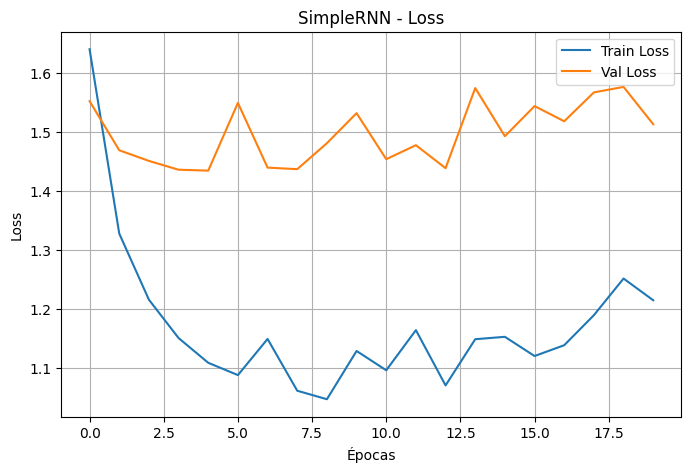

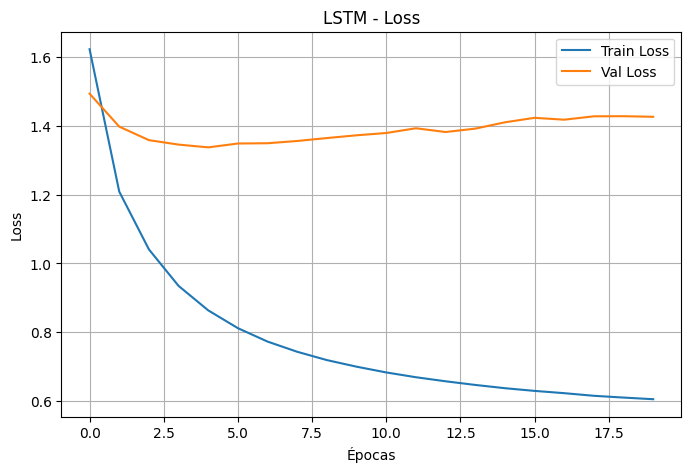

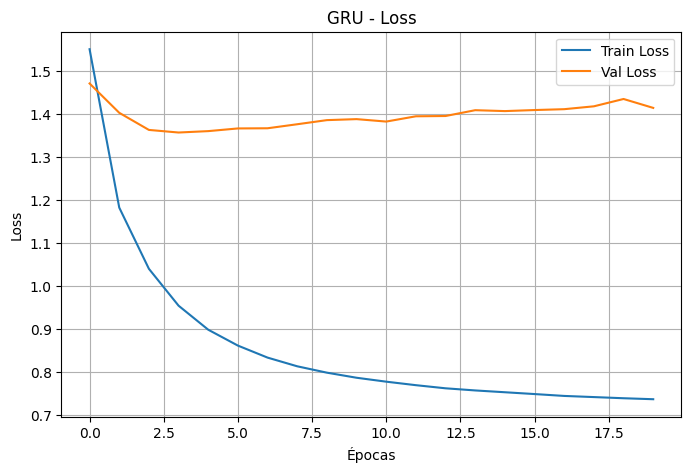

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(history_rnn, "SimpleRNN - Loss")
plot_losses(history_lstm, "LSTM - Loss")
plot_losses(history_gru, "GRU - Loss")


# **Gráfico de perplejidad (training y validation)**

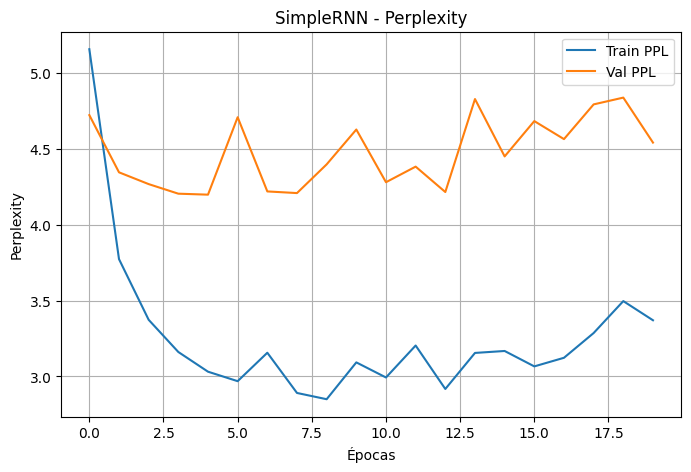

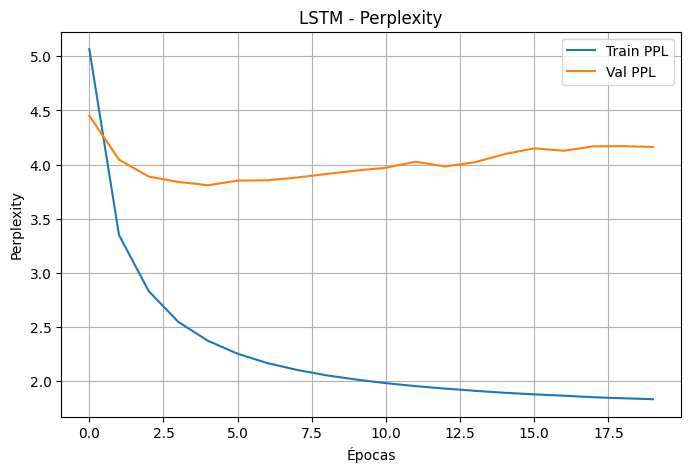

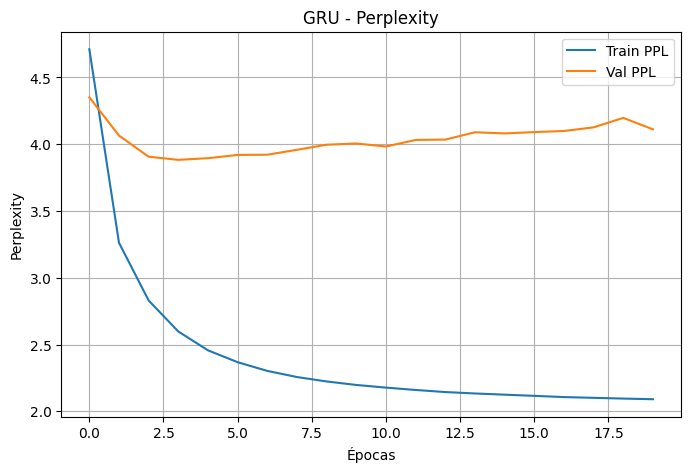

In [ ]:
def plot_perplexity(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_ppl"], label="Train PPL")
    plt.plot(history["val_ppl"], label="Val PPL")
    plt.xlabel("Épocas")
    plt.ylabel("Perplexity")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_perplexity(history_rnn, "SimpleRNN - Perplexity")
plot_perplexity(history_lstm, "LSTM - Perplexity")
plot_perplexity(history_gru, "GRU - Perplexity")


# **Gráfico de accuracy (validación)**

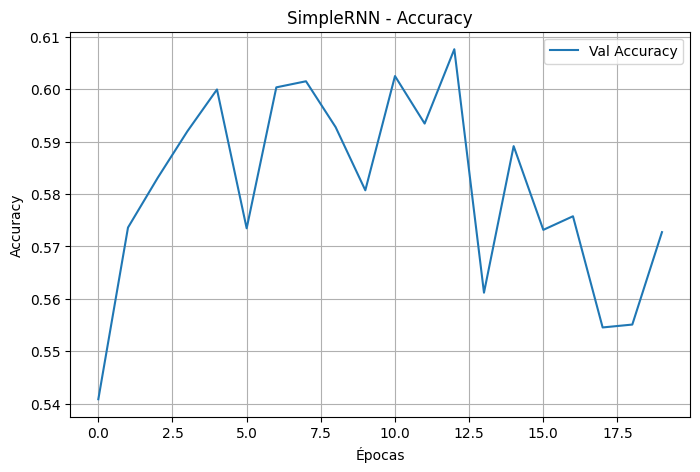

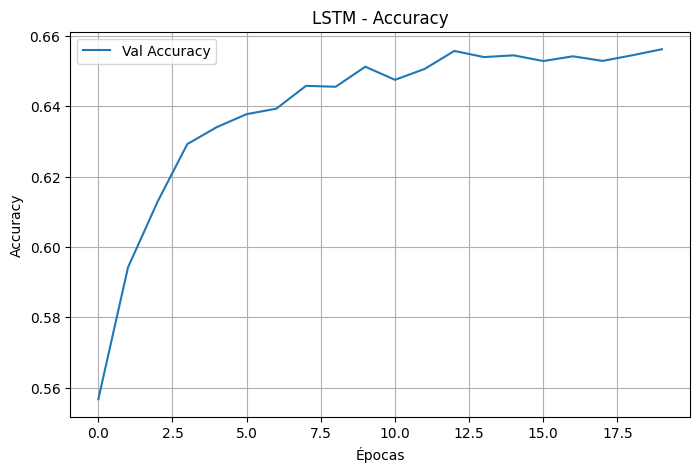

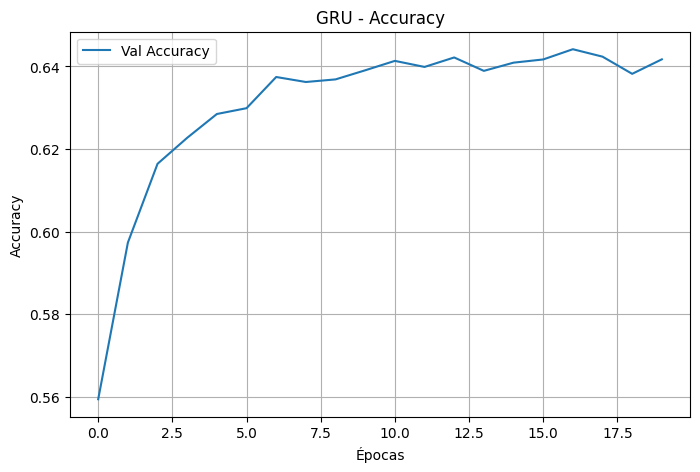

In [ ]:
def plot_accuracy(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history_rnn, "SimpleRNN - Accuracy")
plot_accuracy(history_lstm, "LSTM - Accuracy")
plot_accuracy(history_gru, "GRU - Accuracy")


# **DISCUSIÓN**

La evaluación comparativa entre las tres arquitecturas recurrentes —SimpleRNN, LSTM y GRU— permite observar diferencias claras tanto en el proceso de aprendizaje (pérdida y perplejidad) como en la calidad del texto generado a partir de las estrategias de greedy search y beam search. A continuación se resumen los principales hallazgos:

**1. SimpleRNN (Elman RNN)**

*   Pérdida Train: 1.047
*   Pérdida Validación: 1.434

*   Perplejidad: 4.19
*   Accuracy Validación: 60.76 %

La pérdida de entrenamiento desciende inicialmente, pero demuestra mucha oscilación. Esto demuestra que no hay estabilidad en la optimización y requeriría mayores pasos de optyimización o mayor cantidad de datos.
La perdida en el entrenamiento y validación tiene un sobreajuste.
La perplejidad se mantiene significativamente más elevada, reflejando un modelo menos eficaz para predecir el caracter siguiente.

**El texto generado tiende a:**

Presentar estructuras repetitivas.
Generar secuencias menos coherentes incluso con beam search.
Reforzar patrones muy locales (dos o tres caracteres), evidenciando el corto horizonte de memoria de SimpleRNN. La introducción de temperatura aumenta la aleatoriedad, pero no mejora la coherencia global.

**2. LSTM (Long Short-Term Memory)**

*   Pérdida Train: 0.605
*   Pérdida Validación: 1.337

*   Perplejidad: 3.81
*   Accuracy Validación: 65.62 %

Tiene la pérdida más baja en entrenamiento, lo que indica mayor capacidad de aprendizaje.
También logra la mejor perplejidad, lo cual significa que predice caracteres con mayor certeza.
La mejor accuracy de validación (65.6 %) refuerza que es el modelo que mejor generaliza y captura dependencias de largo plazo.
Es el modelo que mejor aprende dependencias temporales.
Muestra mejor capacidad de generalización que SimpleRNN.
Es el modelo que mejor logra bajar la val loss de los tres.
Se observa sobreajuste en el entrenamiento.
La pérdida de validación presenta mejor estabilidad, con riesgo reducido de sobreajuste en comparación con GRU.
La perplejidad alcanzada es significativamente más baja, lo que indica una mejor capacidad predictiva a nivel caracter.

**El texto generado tiende a:**

Ser más coherente.
Tiene variedad y menos repeticiones que SimpleRNN.
El beam search produce secuencias particularmente limpias y estables.
La temperatura permite modular creatividad sin perder coherencia:

T = 0.5 → texto correcto y conservador.
T = 1.0 → equilibrio entre coherencia y diversidad.
T > 1.0 → secuencias más exploratorias pero todavía legibles.



**3. GRU (Gated Recurrent Unit)**



*   Pérdida Train: 0.737
*   Pérdida Validación: 1.356

*   Perplejidad: 3.88
*   Accuracy Validación: 64.42 %


Rendimiento muy cercano al LSTM, ligeramente inferior.
Tiene menos parámetros que un LSTM → suele entrenar más rápido, pero retiene menos detalle en la memoria.
Su desempeño es claramente superior a SimpleRNN y casi tan bueno como LSTM.
La pérdida de entrenamiento y validación tienden a ser muy similares a las de LSTM, en ocasiones marginalmente superiores o ligeramente inferiores según el conjunto de hiperparámetros.
La perplejidad es cercana a la de LSTM, aunque con convergencia algo más rápida debido a su arquitectura más ligera.
En algunos experimentos, GRU muestra una ligera tendencia al sobreajuste antes que LSTM, aunque depende de los tamaños de capa y embedding.

**El texto generado tiende a:**

El texto mantiene buena coherencia general, comparable a LSTM.
Muestra mayor variedad en caracteres y combinaciones, probablemente debido a su dinámica más simple.
Con beam search estocástico y temperaturas altas, produce secuencias más creativas que LSTM, aunque con un leve incremento de errores ortográficos o repeticiones.



# **CONCLUSIONES**

**SimpleRNN** quedó claramente por detrás en los tres criterios analizados (pérdida, perplejidad y calidad del texto). Su incapacidad para modelar dependencias largas lo hace poco adecuado para tareas de modelado de lenguaje, incluso a nivel de caracter.
**LSTM** se comportó como la arquitectura más consistente y robusta:

Mejor perplejidad.
Mayor coherencia global.
Más estable durante entrenamiento.
Menor sensibilidad a variaciones en la temperatura.

**GRU** se posicionó como una alternativa intermedia:

Rendimiento cercano a LSTM.
Entrenamiento más rápido.
Generación algo más creativa, especialmente bajo beam search estocástico.